the dataset url: [https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset](https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset)

In [15]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("unclesamulus/blood-cells-image-dataset")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'blood-cells-image-dataset' dataset.
Path to dataset files: /kaggle/input/blood-cells-image-dataset


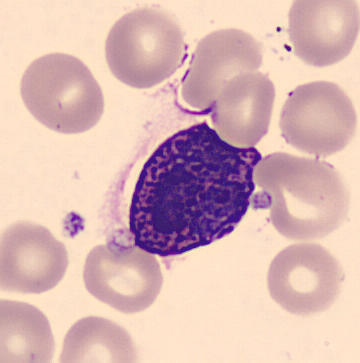

In [16]:
from PIL import Image
import os, glob

root = os.path.join(path, "bloodcells_dataset")

# pick one image from basophil
one_image = glob.glob(os.path.join(root, "basophil", "*.jpg"))[0]

img = Image.open(one_image).convert("RGB")
img


In [17]:
print("PIL image size (width, height):", img.size)

PIL image size (width, height): (360, 363)


The CNN Pipeline: From Data to Evaluation

A Convolutional Neural Network (CNN) goes through a series of steps to process data, learn patterns, and make predictions. This process, often referred to as the CNN pipeline, can be broken down into four main stages: **data preprocessing, model building, training and validation, and evaluation and plotting.**


---



1. Data Preprocessing

This is the crucial first step where you prepare your raw data for the model. For image data, this often involves:

Data Collection: Gathering a large and diverse dataset of images.

Resizing: You must resize all images to a uniform size (e.g., 224x224 pixels) for consistent processing.

Normalization: Pixel values (typically 0-255) are scaled to a smaller range (e.g., 0-1) to help the model converge faster.

Data Augmentation: To prevent overfitting, you can artificially expand your dataset by applying random transformations like rotations, flips, or shifts to existing images.

---

2. Model Building

This is where you define the architecture of your CNN. A typical CNN architecture consists of several key layers:

Convolutional Layers: These layers apply filters (kernels) to the input image to create feature maps, which learn to detect specific features like edges or textures.

Activation Function: An activation function, such as ReLU, introduces non-linearity, allowing the network to learn more complex patterns.

Pooling Layers: These layers, often using max pooling, downsample the feature maps, which reduces computational complexity and makes the model more robust to minor shifts.

Flattening Layer: This layer converts the 2D feature maps into a single, long vector.

Fully Connected Layers: These standard neural network layers take the flattened vector as input to classify the image. The final layer typically has one neuron for each class.

---

3. Training and Validation

Once the model is built, you train it using your preprocessed data. This is an iterative process:

Splitting the Data: You divide your dataset into a training set, a validation set, and a test set. The model learns from the training set, and its performance is fine-tuned using the validation set.

Fine-tuning and the Validation Set: Fine-tuning is a process that optimizes the model's performance and prevents overfitting. While the model doesn't directly update its parameters from the validation set, the developer uses the feedback (accuracy and loss) to make adjustments to hyperparameters (e.g., learning rate, network architecture).

Forward Propagation: This is the "thinking" phase where data is passed through the network to generate a prediction.

An image is fed into the network.

It's processed sequentially through each layer.

The final layer outputs the prediction. This pass is used to make a guess before calculating the error.

Loss Function: A loss function (e.g., cross-entropy) quantifies the error between the model's predictions and the true labels.

Backpropagation: This algorithm uses the loss to efficiently adjust the model's weights and biases to minimize the error.

Optimization: An optimizer (e.g., Adam, SGD) guides the learning process, helping the model find the optimal set of weights.

---

4. Evaluation and Plotting

After training, you evaluate the model's performance on the unseen test set.

Accuracy: This is the percentage of correct predictions the model makes.

Confusion Matrix: A powerful tool that shows a breakdown of the model's predictions, including true positives, false positives, and false negatives, to highlight which classes it struggles with.

Performance Metrics: Other metrics like precision, recall, and the F1-score provide a more nuanced understanding of the model's performance.

Plotting: You can plot the training and validation accuracy and loss over time (epochs). These plots are crucial for diagnosing issues like overfitting (when training accuracy improves but validation accuracy declines) or underfitting (when the model is too simple to learn the data).



---



# 1. Data Preprocessing -------------------------------



---




# Dataset Class

Why build a Dataset class?
PyTorch trains with two building blocks:
Dataset: knows how to get one sample by index (__getitem__) and how many samples exist (__len__).
DataLoader: wraps a Dataset to give you mini-batches, shuffling, and multi-process loading.
We write a tiny custom Dataset because:
Matches Kaggle’s folder layout
Your dataset is organized as:




*bloodcells_dataset/
*    basophil/
*   eosinophil/


*   erythroblast/
*   ig/


*   lymphocyte/
*   monocyte/


*   neutrophil/
*   platelet/\


---




That means labels are implied by subfolder name. Our class turns “folder name → integer label” (e.g., basophil → 0, …).

Lazy & memory-safe
We only store file paths, not image pixels. Images are opened on-the-fly in __getitem__, so you can handle large datasets.

Exact control
Filter .jpg only (your set is JPG 360×363)
Plug any transforms/augmentations you want
Easy to extend later (e.g., return image path, add masks/metadata, etc.)


---


(Yes, you could also use torchvision.datasets.ImageFolder for this structure; we’re writing a custom class to teach the mechanics and to enforce “JPG only”.)

---


# Line-by-line explanation

__init__ (build the index of files and labels)
def __init__(self, root_dir, transform=None):
Constructor. You pass the dataset root path (the folder that contains the eight class subfolders) and an optional transform to preprocess images when loading.


---


self.transform = transform
Store the transform so we can apply it later inside __getitem__. If None, images are returned as raw PIL images.


---


self.classes = sorted([ ... ])
os.listdir(root_dir) lists names inside root_dir.


if os.path.isdir(os.path.join(root_dir, d)) keeps only subfolders (each subfolder is a class).

sorted(...) gives a deterministic order, so your labels don’t change between runs.

*Result: ["basophil","eosinophil",...,"platelet"] (alphabetical).*

self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

Build a mapping class name → integer. Example:
{'basophil':0, 'eosinophil':1, ..., 'platelet':7}

self.image_paths, self.labels = [], []

Create two parallel lists. Same length.

image_paths[k] is a filepath string.

labels[k] is its numeric class index.

for c in self.classes:

Loop over each class name (i.e., each subfolder).

cdir = os.path.join(root_dir, c)

The path to that class folder.

jpgs = glob.glob(os.path.join(cdir, "*.jpg"))

Find only JPG files in the class folder (the dataset states JPG 360×363).

self.image_paths.extend(jpgs)

Append all found JPG paths to the master list.

self.labels.extend([self.class_to_idx[c]] * len(jpgs))

For each image path we just added, append the same label (the class index)
so the two lists stay aligned.


---


__len__ (how many samples?)
return len(self.image_paths)
Tells PyTorch how many examples you have. DataLoader uses this to know when an epoch ends.

---

__getitem__ (how to load one sample by index)

img = Image.open(self.image_paths[idx]).convert("RGB")

Open the file at position idx as a PIL image.

.convert("RGB") ensures exactly 3 channels (useful if any grayscale slipped in).

label = self.labels[idx]

Fetch the integer label for that same index.

if self.transform: img = self.transform(img)

If you passed a transform at construction time, apply it now (e.g., resize, normalize, augment). This is where PIL becomes a torch tensor if your transform includes ToTensor().

return img, label
Return a tuple.

The DataLoader will stack many of these into a batch:
img becomes a tensor batch of shape [B, C, H, W]; label becomes a tensor [B] of ints.
---


In [18]:
CLASSES = [
    "basophil",
    "eosinophil",
    "erythroblast",
    "ig",
    "lymphocyte",
    "monocyte",
    "neutrophil",
    "platelet",
]


In [19]:
from torch.utils.data import Dataset

class BloodCellsDataset(Dataset):
    """
    PyTorch Dataset for the 'Blood Cells Image Dataset'.

    - Expects the Kaggle structure with one subfolder per class:
        root_dir/
          basophil/
          eosinophil/
          ...
          platelet/
    - Labels are derived from subfolder names.
    - Only '*.jpg' files are indexed (dataset is JPG 360x363).

    Attributes created:
        self.classes: list[str]        # sorted class names
        self.class_to_idx: dict[str,int]
        self.image_paths: list[str]    # absolute file paths to JPGs
        self.labels: list[int]         # integer labels aligned with image_paths
    """
    def __init__(self, root_dir, transform=None):
        self.transform = transform #we will define it in the next cell

        # 1) discover classes from subfolders (sorted for stable indices)
        self.classes = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        # 2) collect ONLY .jpg files and their labels
        self.image_paths, self.labels = [], []
        for c in self.classes:
            cdir = os.path.join(root_dir, c)
            jpgs = glob.glob(os.path.join(cdir, "*.jpg"))  # JPG only
            self.image_paths.extend(jpgs)
            self.labels.extend([self.class_to_idx[c]] * len(jpgs))

    def __len__(self):
        # required by DataLoader to know how many samples exist
        return len(self.image_paths)

    def __getitem__(self, idx):
        # required by DataLoader to fetch a single (image, label) pair
        img = Image.open(self.image_paths[idx]).convert("RGB")  # guarantees 3 channels
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


**Transform**

Why do we pass transform?

1. Resize images to a size your model expects (e.g., 224×224 for many pretrained nets).

2. Normalize to the same mean/std as ImageNet (common for transfer learning).

3. Augment training data (random crop/flip/rotate/color jitter) to reduce overfitting and improve generalization.

Keep the Dataset reusable: you can create one dataset for training (with augmentations) and another for validation/test (no augmentation, just deterministic resizing + normalize).

Why 224×224?
It’s the default for many pretrained architectures (ResNet, DenseNet, EfficientNet-B0). Using 224 means you can switch to transfer learning easily.

In [20]:
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode


IMG_SIZE = 224  # common input size for ResNet/DenseNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]


# Use a light fill (white) or something close to the background
LIGHT_FILL = (255, 255, 255)

# Training: with augmentation
train_tfms = T.Compose([
    # RandomResizedCrop: randomly crops and scales the image, then resizes to IMG_SIZE
    #   - Helps the model become robust to scale/position changes
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    # RandomHorizontalFlip: sometimes flip left↔right
    T.RandomHorizontalFlip(),
    # RandomRotation: small rotations; cells don’t have a canonical orientation
    T.RandomRotation(10, interpolation=InterpolationMode.BILINEAR, fill=LIGHT_FILL),
    # ColorJitter: small changes in brightness/contrast/saturation to mimic stain variations
    T.ColorJitter(0.2, 0.2, 0.2),
    # ToTensor: PIL (H,W,C in [0..255]) → torch (C,H,W in [0..1])
    T.ToTensor(),
    # Normalize: center & scale channels to ImageNet stats (helps pretrained models)
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Validation/Test: no randomness → repeatable metrics
val_tfms = T.Compose([
    # Make the long edge ~256 then crop to 224 center (standard eval pipeline)
    T.Resize(256),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [21]:
ds = BloodCellsDataset(root)  # no transforms, pure PIL inside
print("Discovered classes:", ds.classes)
print("Mapping:", ds.class_to_idx)
print("Total images:", len(ds))

# Per-class counts
for c in ds.classes:
    n = len(glob.glob(os.path.join(root, c, "*.jpg")))
    print(f"{c:<15} {n:>5}")

# PIL shape BEFORE tensors
from PIL import Image
img = Image.open(ds.image_paths[0]).convert("RGB")
print("PIL size (W,H):", img.size)
print("Channels:", len(img.getbands()))  # ('R','G','B') → 3


Discovered classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Mapping: {'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6, 'platelet': 7}
Total images: 17092
basophil         1218
eosinophil       3117
erythroblast     1551
ig               2895
lymphocyte       1214
monocyte         1420
neutrophil       3329
platelet         2348
PIL size (W,H): (360, 363)
Channels: 3


In [22]:
#now using transforms:
ds_t = BloodCellsDataset(root, transform=val_tfms)

print("Discovered classes:", ds_t.classes)
print("Mapping:", ds_t.class_to_idx)
print("Total images:", len(ds_t))
#You should see the same classes & counts as before; transforms don’t change dataset size.

#But ....

#Pick one transformed sample and inspect shapes
# Get one (image_tensor, label)
x, y = ds_t[0]

print(type(x))            # torch.Tensor
print("Tensor shape:", x.shape)  # expect torch.Size([3, 224, 224])
print("Channels:", x.shape[0])
print("Height:",   x.shape[1])
print("Width:",    x.shape[2])
print("Label index:", y, "->", ds_t.classes[y])

# Value range after Normalize ≈ around [-2.5, +2.5]
print("Tensor stats — min:", float(x.min()), "max:", float(x.max()))

#What’s happening?
#ToTensor() converts PIL → Tensor and reorders to (C, H, W).
#Resize/CenterCrop make it 224×224.
#Normalize scales channels using ImageNet mean/std so transfer-learning backbones behave well.


Discovered classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Mapping: {'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6, 'platelet': 7}
Total images: 17092
<class 'torch.Tensor'>
Tensor shape: torch.Size([3, 224, 224])
Channels: 3
Height: 224
Width: 224
Label index: 0 -> basophil
Tensor stats — min: -1.843137264251709 max: 2.248908281326294


**create dataset object and Split the data into train test set**


In [23]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, DataLoader
from collections import Counter
import glob, os

# 1) Create the base dataset (no transforms) just to index files/labels
dataset = BloodCellsDataset(root)           # no transforms here

# 2) Stratified split: 70% train, 15% val, 15% test
labels  = np.array(dataset.labels)
indices = np.arange(len(dataset))

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(sss1.split(indices, labels))

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_rel, test_rel = next(sss2.split(temp_idx, labels[temp_idx]))
val_idx  = temp_idx[val_rel]
test_idx = temp_idx[test_rel]

print(f"Split sizes → Train: {len(train_idx)} | Val: {len(val_idx)} | Test: {len(test_idx)}")

# 3) Build transformed subsets
#    (use the transforms we defined earlier: train_tfms / val_tfms)
train_ds = Subset(BloodCellsDataset(root, transform=train_tfms), train_idx)
val_ds   = Subset(BloodCellsDataset(root, transform=val_tfms),   val_idx)
test_ds  = Subset(BloodCellsDataset(root, transform=val_tfms),   test_idx)



Split sizes → Train: 11964 | Val: 2564 | Test: 2564


**Create DataLoaders and check batch shapes**

In [24]:
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

xb, yb = next(iter(train_loader))
print("\nBatch shapes →", xb.shape, yb.shape)  # expected: [B, 3, 224, 224], [B]


Batch shapes → torch.Size([32, 3, 224, 224]) torch.Size([32])


#### Display some images

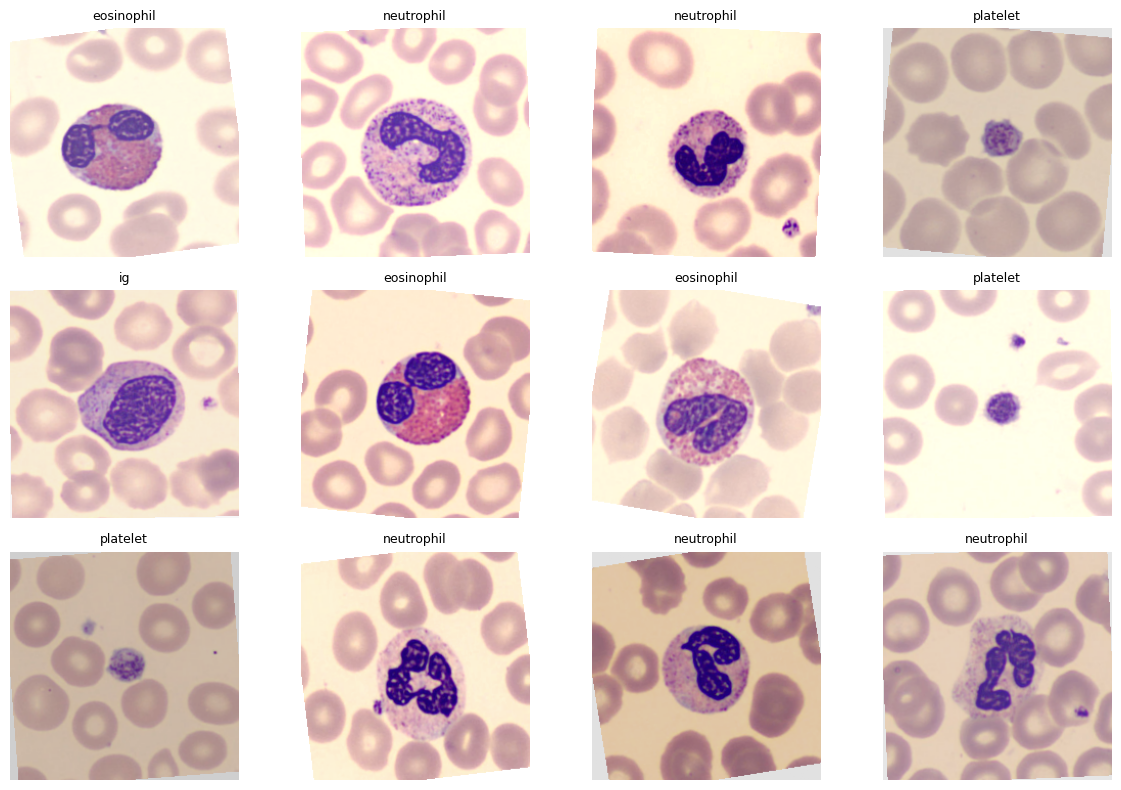

In [25]:
import matplotlib.pyplot as plt
import torch

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def _unnormalize(img_t):
    # img_t: Tensor [3, H, W] normalized with ImageNet stats
    mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
    std  = torch.tensor(IMAGENET_STD).view(3,1,1)
    return (img_t * std + mean).clamp(0, 1)

def _base_dataset_from_loader(dl):
    ds = dl.dataset
    # peel Subset(Subset(...)) layers until we reach the base Dataset
    while hasattr(ds, "dataset"):
        ds = ds.dataset
    return ds

def show_batch(dl, n=12):
    xb, yb = next(iter(dl))  # xb: [B, 3, H, W], yb: [B]
    classes = _base_dataset_from_loader(dl).classes
    n = min(n, xb.size(0))

    plt.figure(figsize=(12, 8))
    for i in range(n):
        plt.subplot(3, 4, i+1)
        img = _unnormalize(xb[i]).permute(1, 2, 0).numpy()  # [H,W,C] in [0,1]
        plt.imshow(img)
        plt.title(classes[int(yb[i])], fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


show_batch(train_loader, n=12)


**the images are rotated is because:
Square crops with slight rotations → the train augmentations (crop/rotate/flip) are being applied.**

---



# 2.  Model Building



---


Why weights? the dataset is imbalanced (e.g., neutrophils > lymphocytes).
Plain cross-entropy tends to favor common classes. Class weights up-weight rare classes so their mistakes “count more.”


What this formula does:
cnt[c] = how many training samples belong to class c.
For each class c, weight = N / (K * cnt[c]).
If cnt[c] is small (rare class), the weight is larger.
If cnt[c] is big (common class), the weight is smaller.
Nice property: the average weight per sample ≈ 1

That keeps the overall loss scale stable.
Important: We compute weights from the train set only (no peeking at val/test).

Big picture
features: three Conv→ReLU→MaxPool blocks extract visual features (edges → textures → cell shapes).
classifier: two Linear layers turn the features into class scores (logits).
Dropout: randomly zeroes activations during training (regularization that reduces overfitting).

---

Input & feature map sizes (with your 224×224 transforms)
Input to the net: [B, 3, 224, 224] (batch, channels, height, width)


Conv2d(3, 32, kernel=3, padding=1)
Padding keeps spatial size the same for a 3×3 kernel (“same” conv): 224×224 → 224×224, channels 3→32


MaxPool2d(2) halves H and W: 224 → 112




Second block: 32→64 channels, then pool 112 → 56


Third block: 64→128 channels, then pool 56 → 28


After 3 pools, spatial size is 224 / 2 / 2 / 2 = 28.


So right before the classifier:
tensor is [B, 128, 28, 28].
Flattening per sample gives 128*28*28 = 100,352 features.
Hence the first linear layer is:
nn.Linear(100352, 256)


Why 224//8?

Because three MaxPool2d(2) divide the size by
2
×
2
× 2 =
8
2×2×2=8.


If you change your input size (e.g., to 192), you must adjust this. See “Make it resolution-agnostic” below.

---

What each layer does
Conv2d: learns spatial filters (3×3) to detect local patterns.
ReLU: non-linearity that keeps positives, zeroes negatives. Cheap and works well.
MaxPool2d(2): makes features translation-tolerant and reduces compute (downsamples).
Dropout(0.25/0.5): randomly zeroes neurons during training → encourages redundancy and generalization.
Linear(…, 256) → ReLU → Dropout(0.5): compact head with regularization.
Linear(256, num_classes): final logits; softmax is applied implicitly inside CrossEntropyLoss.

---

Parameter counts (intuition for capacity)
Conv1:
(
3 ×
3 ×
3 ) ×
32 +
32 ≈
896
(3×3×3)×32+32≈896


Conv2:
(
3
×
3
×
32
)
×
64
+
64
≈
18
,
496
(3×3×32)×64+64≈18,496


Conv3:
(
3
×
3
×
64
)
×
128
+
128
≈
73
,
856
(3×3×64)×128+128≈73,856


FC1:
100
,
352
×
256
+
256
≈
25.69
M
100,352×256+256≈25.69M ← most of the parameters live here


FC2:
256
×
8
+
8 =
2 , 056


256×8+8=2,056

---

The model is dominated by the first linear layer. That’s normal for small CNNs feeding a big fully-connected layer.

.to(device)
Moves the model’s parameters to GPU or CPU (must match the device you move batches to).

In [26]:
import torch, torch.nn as nn
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #picks GPU (“cuda”) if Colab has one, otherwise CPU.
#You’ll later send tensors and the model to this device so math runs there.
num_classes = len(dataset.classes)

# ---- class-weighted loss (computed on TRAIN ONLY) ----
train_labels = [dataset.labels[i] for i in train_idx]
cnt = Counter(train_labels)
N, K = len(train_labels), num_classes
class_weights = torch.tensor([N/(K*cnt[c]) for c in range(K)], dtype=torch.float32).to(device)


# ---- simple CNN ----
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*(224//8)*(224//8), 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        return self.classifier(x)

model = SmallCNN(num_classes).to(device)



CrossEntropyLoss(weight=class_weights)
Combines log-softmax + negative log-likelihood into one loss.
weight=class_weights applies the per-class multipliers we computed, so rare classes contribute more to the loss.



---



Adam (optimizer)
Adaptive learning rates per parameter.
lr=1e-3: good starter LR for Adam on small models.
weight_decay=1e-4: L2 regularization; discourages very large weights → less overfitting.




---





ReduceLROnPlateau
Watches your validation metric (we pass it val accuracy after each epoch).
mode="max": larger is better.
If val acc doesn’t improve for 2 epochs (patience=2), multiply LR by 0.5 (factor=0.5).
This “auto-tuning” helps you squeeze a bit more performance after you hit a plateau.


Tip: Always call scheduler.step(val_metric) after you compute val accuracy each epoch (you do this in your training loop).

In [27]:

# Loss function & optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)


---



# 3.  Training and Validation



---



A. Two different passes: training vs validation
Training (train_one_epoch)
We learn: do forward → compute loss → backprop gradients → update weights with the optimizer.
model.train() turns on training behaviors (e.g., dropout).
Validation (validate)
We measure on unseen validation data. No weight updates.
model.eval() turns off dropout and uses stable BatchNorm stats.
torch.no_grad() disables autograd so it runs faster and uses less memory.
Keeping these separate prevents subtle bugs (like accidentally training during validation).



---


B. Why we weight batch losses by batch size
Each batch’s loss.item() is already the mean over that batch.
If you naïvely average these means, the last small batch would count the same as a full batch — that’s biased.
So we accumulate batch_mean_loss × batch_size and divide once by the total number of samples.
That yields the true dataset mean loss.
Same idea for accuracy: we count total correct predictions and divide by total samples.



---

C. What the scheduler is doing (and why here)
You’re using ReduceLROnPlateau with mode="max". That means “bigger is better”—so you feed it validation accuracy.
If val acc stops improving for a few epochs (patience inside the scheduler, not the same as early-stopping patience), it reduces the learning rate (multiplies by factor=0.5).
Smaller LR helps you escape plateaus gently and often squeezes out a bit more performance.
If you prefer to monitor val loss, create the scheduler with mode="min" and call scheduler.step(va_loss) instead.


---


D. Why we checkpoint and early-stop on validation accuracy
Checkpointing: whenever val acc improves, we save the current weights as the best model.
At the end, you reload this checkpoint to evaluate on the test set. That ensures you report the best generalizing model, not just the last one.
Early stopping: if val acc hasn’t improved in patience consecutive epochs, we stop training.
This prevents overfitting and saves time.
You chose patience=5 in fit — a nice default for this dataset/size.


---


E. What each print line tells you
[CNN] Epoch 07 | train acc 0.894 loss 0.267 | val acc 0.904 loss 0.240
Train acc/loss: how well the model fit the (augmented) training data this epoch.
(Dropout + data augmentation often make training slightly tougher.)
Val acc/loss: honest generalization snapshot — the number you should trust.
Healthy trend:
Train loss ↓, Val loss ↓
Train acc ↑, Val acc ↑
Watch out for:
Overfitting: Train acc keeps climbing, Val acc plateaus or dips, Val loss rises.
Underfitting: Both accs low; losses stay high → consider a bigger model, more epochs, stronger aug, or a better LR schedule.


---



F. The history dict: why we keep it
You fill:
history["tr_loss"], history["va_loss"]
history["tr_acc"], history["va_acc"]
This lets you plot both curves later:
Loss curves diagnose learning dynamics and over/underfitting.
Accuracy curves show overall performance improvements.
(You already wrote a plot_curves(...)—just pass this history.)

---


Common mistakes this structure avoids


1. Forgetting model.eval() during validation (dropout stays on → noisy, wrong metrics).


2. Forgetting torch.no_grad() during validation (slow + wasted memory).


3. Averaging batch losses without weighting by batch size.


4. Stepping the scheduler on training metrics (should use validation).


5. Saving only the last model instead of the best model (by val metric).


6. Mixing transforms (augmenting validation/test).


In [28]:
# ---------------------------
# Validation
# ---------------------------
def validate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad(): # disable autograd → faster, less memory
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)                 # forward only # logits: [B, num_classes]
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)     # batch mean × batch size
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    return total_loss / total, correct / total


# ---------------------------
# Single training epoch
# ---------------------------
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)                     # forward
        loss = criterion(outputs, labels)          # CE (with class weights)
        loss.backward()                            # backward (backprop → fills param.grad)
        optimizer.step()                           # # update params (Adam here)

        total_loss += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

    return total_loss / total, correct / total


# ---------------------------
# Fit loop that calls train/validate per epoch
# ---------------------------
def fit(model, train_loader, val_loader, optimizer, criterion,
        scheduler=None, epochs=25, patience=5, save_path="/content/best_cnn.pt"):
    """
    Runs a training loop with:
      - per-epoch train + validate
      - optional ReduceLROnPlateau scheduler (stepped on val acc)
      - early stopping on val acc
      - checkpoint best weights to `save_path`
    Returns: history dict to plot curves.
    """
    best_val, wait = 0.0, 0
    history = {"tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss, va_acc = validate(model, val_loader, criterion)

        # log
        history["tr_loss"].append(tr_loss); history["tr_acc"].append(tr_acc)
        history["va_loss"].append(va_loss); history["va_acc"].append(va_acc)

        # scheduler on validation accuracy (if provided)
        if scheduler is not None:
            # for ReduceLROnPlateau(mode="max"): pass the metric you care about
            scheduler.step(va_acc)

        print(f"[CNN] Epoch {epoch:02d} | "
              f"train acc {tr_acc:.3f} loss {tr_loss:.3f} | "
              f"val acc {va_acc:.3f} loss {va_loss:.3f}")

        # checkpoint + early stopping (by val accuracy)
        if va_acc > best_val:
            best_val, wait = va_acc, 0
            torch.save(model.state_dict(), save_path)
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    return history

history = fit(
    model, train_loader, val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,      # your ReduceLROnPlateau
    epochs=25,
    patience=5,
    save_path="/content/best_cnn.pt"
)



[CNN] Epoch 01 | train 0.528 | val 0.739
[CNN] Epoch 02 | train 0.765 | val 0.807
[CNN] Epoch 03 | train 0.830 | val 0.900
[CNN] Epoch 04 | train 0.856 | val 0.920
[CNN] Epoch 05 | train 0.878 | val 0.897
[CNN] Epoch 06 | train 0.881 | val 0.943
[CNN] Epoch 07 | train 0.894 | val 0.904
[CNN] Epoch 08 | train 0.898 | val 0.894
[CNN] Epoch 09 | train 0.901 | val 0.930
[CNN] Epoch 10 | train 0.924 | val 0.943
[CNN] Epoch 11 | train 0.926 | val 0.950
[CNN] Epoch 12 | train 0.929 | val 0.933
[CNN] Epoch 13 | train 0.932 | val 0.945
[CNN] Epoch 14 | train 0.933 | val 0.949
[CNN] Epoch 15 | train 0.943 | val 0.950
[CNN] Epoch 16 | train 0.946 | val 0.955
[CNN] Epoch 17 | train 0.949 | val 0.949
[CNN] Epoch 18 | train 0.950 | val 0.956
[CNN] Epoch 19 | train 0.950 | val 0.953
[CNN] Epoch 20 | train 0.948 | val 0.952
[CNN] Epoch 21 | train 0.952 | val 0.954
[CNN] Epoch 22 | train 0.957 | val 0.954
[CNN] Epoch 23 | train 0.955 | val 0.959
[CNN] Epoch 24 | train 0.959 | val 0.962
[CNN] Epoch 25 |

In [29]:
!pip -q install timm
import timm

tl = timm.create_model("resnet50", pretrained=True, num_classes=num_classes).to(device)

# Phase 1: freeze backbone (train classifier head)
for n, p in tl.named_parameters():
    if "fc" not in n:
        p.requires_grad = False

optimizer_tl = torch.optim.Adam(filter(lambda p: p.requires_grad, tl.parameters()), lr=1e-3, weight_decay=1e-4)
criterion_tl = nn.CrossEntropyLoss(weight=class_weights)
scheduler_tl = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_tl, mode="max", factor=0.5, patience=2)

def train_eval(model, opt, crit, sch, epochs, tag):
    best, wait, patience = 0.0, 0, 5
    for e in range(1, epochs+1):
        # train
        model.train()
        total, correct, loss_sum = 0, 0, 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * yb.size(0)
            correct  += (logits.argmax(1)==yb).sum().item()
            total    += yb.size(0)
        tr_acc = correct/total

        # val
        tl.eval()
        total, correct, loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = tl(xb)
                loss = crit(logits, yb)
                loss_sum += loss.item() * yb.size(0)
                correct  += (logits.argmax(1)==yb).sum().item()
                total    += yb.size(0)
        va_acc = correct/total
        sch.step(va_acc)
        print(f"[ResNet50-{tag}] Epoch {e:02d} | train {tr_acc:.3f} | val {va_acc:.3f}")
        if va_acc > best:
            best, wait = va_acc, 0
            torch.save(model.state_dict(), f"/content/best_resnet50_{tag}.pt")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

# Phase 1: head only
train_eval(tl, optimizer_tl, criterion_tl, scheduler_tl, epochs=6, tag="frozen")

# Phase 2: unfreeze last block + head, lower LR
for n, p in tl.named_parameters():
    if "layer4" in n or "fc" in n:
        p.requires_grad = True

optimizer_tl = torch.optim.Adam(filter(lambda p: p.requires_grad, tl.parameters()), lr=3e-4, weight_decay=1e-4)
scheduler_tl = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_tl, mode="max", factor=0.5, patience=2)

train_eval(tl, optimizer_tl, criterion_tl, scheduler_tl, epochs=14, tag="unfrozen")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

[ResNet50-frozen] Epoch 01 | train 0.568 | val 0.702
[ResNet50-frozen] Epoch 02 | train 0.712 | val 0.749
[ResNet50-frozen] Epoch 03 | train 0.743 | val 0.754
[ResNet50-frozen] Epoch 04 | train 0.767 | val 0.780
[ResNet50-frozen] Epoch 05 | train 0.771 | val 0.805
[ResNet50-frozen] Epoch 06 | train 0.787 | val 0.791
[ResNet50-unfrozen] Epoch 01 | train 0.879 | val 0.931
[ResNet50-unfrozen] Epoch 02 | train 0.931 | val 0.949
[ResNet50-unfrozen] Epoch 03 | train 0.946 | val 0.953
[ResNet50-unfrozen] Epoch 04 | train 0.953 | val 0.969
[ResNet50-unfrozen] Epoch 05 | train 0.960 | val 0.970
[ResNet50-unfrozen] Epoch 06 | train 0.964 | val 0.966
[ResNet50-unfrozen] Epoch 07 | train 0.967 | val 0.963
[ResNet50-unfrozen] Epoch 08 | train 0.970 | val 0.971
[ResNet50-unfrozen] Epoch 09 | train 0.971 | val 0.971
[ResNet50-unfrozen] Epoch 10 | train 0.974 | val 0.969
[ResNet50-unfrozen] Epoch 11 | train 0.976 | val 0.973
[ResNet50-unfrozen] Epoch 12 | train 0.973 | val 0.973
[ResNet50-unfrozen] Ep

---



# 4.  Evaluation and Plotting



---


In [ ]:

import torch, numpy as np, json
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt, seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_preds(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            y_true.append(yb.cpu().numpy())
            y_pred.append(logits.argmax(1).cpu().numpy())
    return np.concatenate(y_true), np.concatenate(y_pred)

def evaluate_and_plot(model, loader, class_names, tag="Model"):
    # Predictions
    y_true, y_pred = get_preds(model, loader)

    # --- Accuracy ---
    acc = accuracy_score(y_true, y_pred)
    print(f"\n== {tag} — Test Accuracy: {acc:.4f}")

    # --- Confusion Matrix (normalized by true class) ---
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{tag} – Confusion Matrix (Normalized)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

    # --- Precision / Recall / F1 (per class + macro avg) ---
    print("\nClassification Report (per class + averages):")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    return acc


In [35]:
# --- Rebuild models and load your best checkpoints ---

# 1) Small CNN (same architecture you trained)
class SmallCNN(torch.nn.Module):
    def __init__(self, num_classes):
       super().__init__()
       self.features = torch.nn.Sequential(
           torch.nn.Conv2d(3,32,3,padding=1), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
           torch.nn.Conv2d(32,64,3,padding=1), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
           torch.nn.Conv2d(64,128,3,padding=1), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
           torch.nn.Dropout(0.25),
       )
       self.classifier = torch.nn.Sequential(
           torch.nn.Linear(128*(224//8)*(224//8), 256), torch.nn.ReLU(), torch.nn.Dropout(0.5),
           torch.nn.Linear(256, len(dataset.classes)),
       )
    def forward(self, x):
       x = self.features(x)
       x = x.flatten(1)
       return self.classifier(x)

cnn = SmallCNN(num_classes=len(dataset.classes)).to(device)
cnn.load_state_dict(torch.load("/content/best_cnn.pt", map_location=device))

# 2) ResNet50 (fine-tuned)
import timm
resnet = timm.create_model("resnet50", pretrained=False, num_classes=len(dataset.classes)).to(device)
resnet.load_state_dict(torch.load("/content/best_resnet50_unfrozen.pt", map_location=device))


<All keys matched successfully>


== Small CNN — Test Accuracy: 0.9657


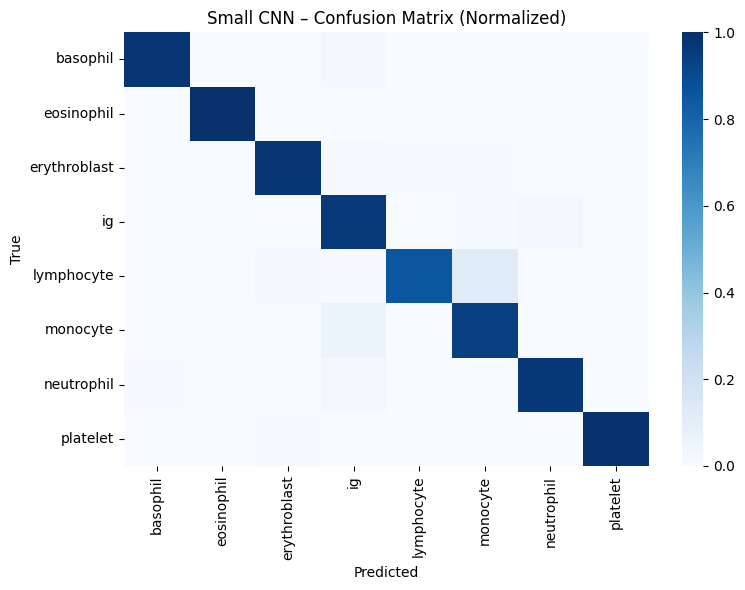


Classification Report (per class + averages):
              precision    recall  f1-score   support

    basophil     0.9834    0.9727    0.9780       183
  eosinophil     1.0000    1.0000    1.0000       467
erythroblast     0.9742    0.9742    0.9742       233
          ig     0.9207    0.9631    0.9414       434
  lymphocyte     0.9810    0.8516    0.9118       182
    monocyte     0.8696    0.9390    0.9029       213
  neutrophil     0.9797    0.9660    0.9728       500
    platelet     1.0000    0.9886    0.9943       352

    accuracy                         0.9657      2564
   macro avg     0.9636    0.9569    0.9594      2564
weighted avg     0.9669    0.9657    0.9658      2564


== ResNet50 (fine-tuned) — Test Accuracy: 0.9750


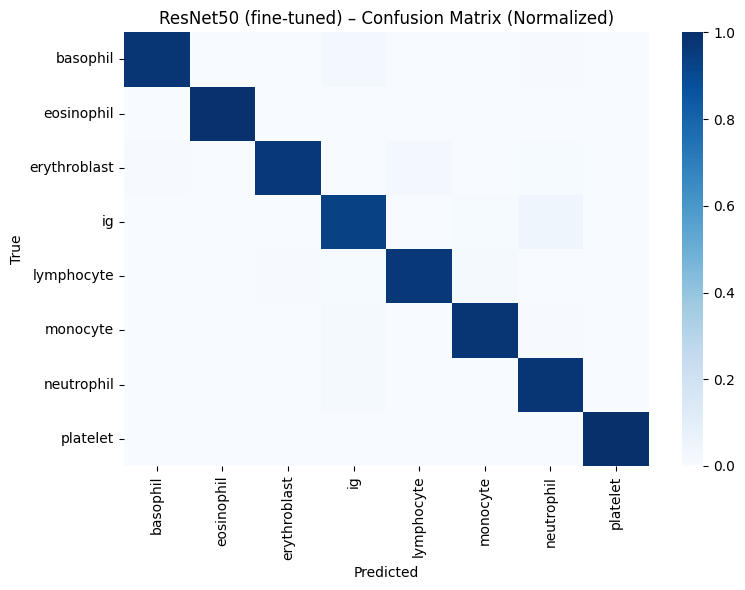


Classification Report (per class + averages):
              precision    recall  f1-score   support

    basophil     0.9889    0.9727    0.9807       183
  eosinophil     1.0000    0.9957    0.9979       467
erythroblast     0.9956    0.9657    0.9804       233
          ig     0.9531    0.9355    0.9442       434
  lymphocyte     0.9724    0.9670    0.9697       182
    monocyte     0.9585    0.9765    0.9674       213
  neutrophil     0.9478    0.9800    0.9636       500
    platelet     1.0000    1.0000    1.0000       352

    accuracy                         0.9750      2564
   macro avg     0.9770    0.9741    0.9755      2564
weighted avg     0.9753    0.9750    0.9751      2564


Summary → CNN Acc: 0.9657 | ResNet50 Acc: 0.9750


In [36]:
# --- Evaluate both on TEST ---
acc_cnn    = evaluate_and_plot(cnn,    test_loader, dataset.classes, tag="Small CNN")
acc_resnet = evaluate_and_plot(resnet, test_loader, dataset.classes, tag="ResNet50 (fine-tuned)")

print(f"\nSummary → CNN Acc: {acc_cnn:.4f} | ResNet50 Acc: {acc_resnet:.4f}")


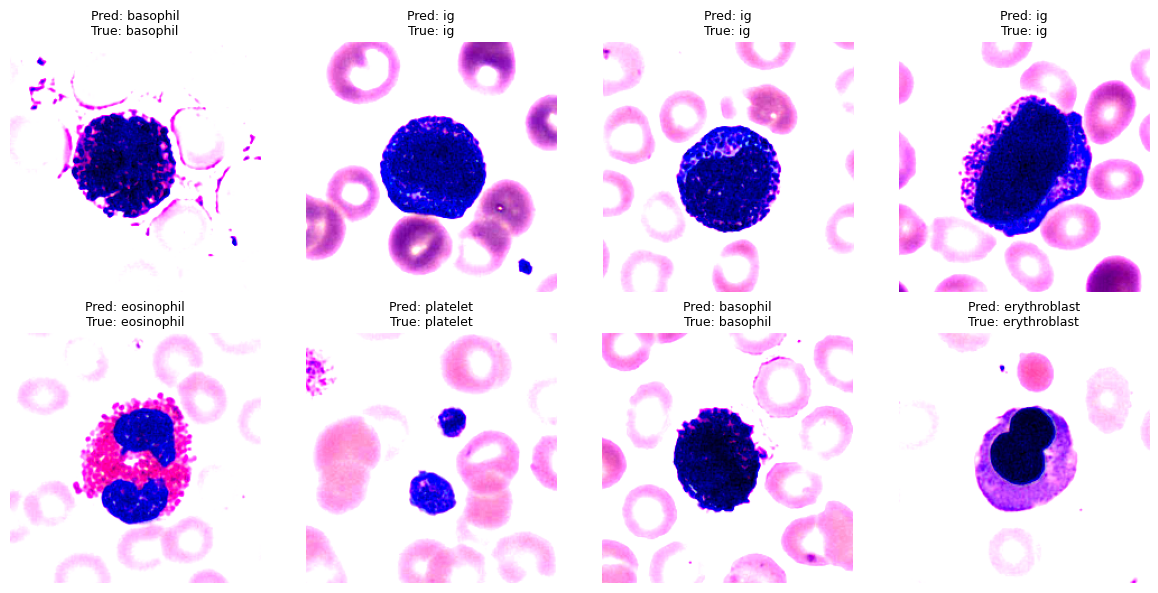

In [38]:
def show_predictions(model, dataloader, n=8):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images[:n].to(device), labels[:n]

    with torch.no_grad():
        outputs = model(images)
        _, preds = outputs.max(1)

    plt.figure(figsize=(12,6))
    for i in range(n):
        plt.subplot(2,4,i+1)
        img = images[i].cpu().permute(1,2,0).numpy()
        plt.imshow(img)
        plt.title(f"Pred: {CLASSES[preds[i]]}\nTrue: {CLASSES[labels[i]]}", fontsize=9)
        plt.axis('off')
    plt.tight_layout(); plt.show()

show_predictions(cnn, test_loader)


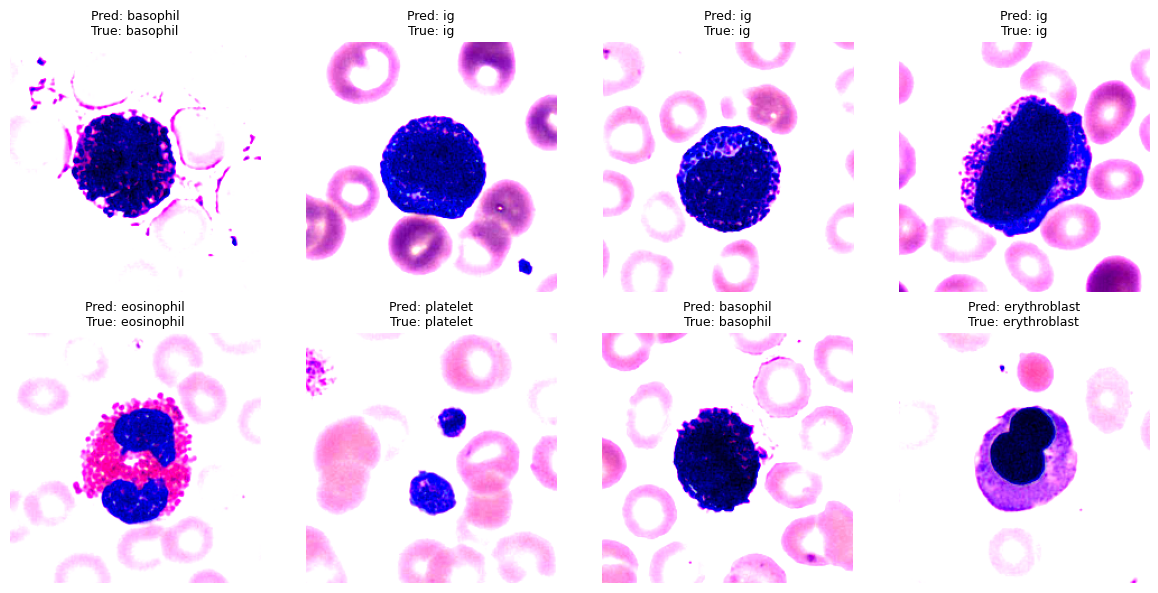

In [39]:
def show_predictions(model, dataloader, n=8):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images[:n].to(device), labels[:n]

    with torch.no_grad():
        outputs = model(images)
        _, preds = outputs.max(1)

    plt.figure(figsize=(12,6))
    for i in range(n):
        plt.subplot(2,4,i+1)
        img = images[i].cpu().permute(1,2,0).numpy()
        plt.imshow(img)
        plt.title(f"Pred: {CLASSES[preds[i]]}\nTrue: {CLASSES[labels[i]]}", fontsize=9)
        plt.axis('off')
    plt.tight_layout(); plt.show()

show_predictions(resnet, test_loader)


